# 4. Deployment

In this section we will apply the exact same preprocessing pipeline to the hold-out test set, ensuring feature alignment with the training data, train our final XGBoost classifier on the full dataset, and generate the submission file for the Kaggle challenge.

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, make_scorer, zero_one_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate, cross_val_predict, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import tree
from xgboost import XGBClassifier
import pandas as pd
import sys
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import fcntl
import warnings
import time



warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=r".*use_label_encoder.*")

## 1. Preparing the data

In [48]:
# Load dataset
test_df = pd.read_csv('./Data/test.csv')

To mirror our treatment of missing values in training, we assign numerical defaults of zero (which correspond to log-transformed 0 after our log1p step) and use “unknown” for missing categorical entries. This preserves row count and keeps encoding consistent.

In [49]:
for col in test_df.columns:
    if pd.api.types.is_numeric_dtype(test_df[col]):
        test_df[col].fillna(0, inplace=True)
    else:
        test_df[col].fillna("unknown", inplace=True)

In [50]:
numeric_columns = test_df.select_dtypes(include=['int64', 'float64'])

In [51]:
test_ids = test_df['id']

test_df = test_df.drop(columns='id')

In [52]:
test_df['cap-diameter'] = pd.to_numeric(test_df['cap-diameter'], errors='coerce').fillna(0)

In [53]:
print(test_df['stem-height'].dtype)

float64


Categories occurring in less than 1% of the test data are recast to “Rare” in order to limit one-hot dimensionality while preserving potentially informative minority patterns

In [54]:
categorical_features = test_df.select_dtypes(include='object').columns.tolist()

threshold = 0.01

for col in categorical_features:
    frequency = test_df[col].value_counts(normalize=True)
    rare_labels = frequency[frequency < threshold].index
    test_df[col] = test_df[col].replace(rare_labels, 'Rare')

Applying log1p to continuous measurements reduces skew and compresses extreme values, improving numerical stability for tree-based learners.

In [55]:
numeric_features = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_features:
    test_df[col] = np.log1p(test_df[col])


In [56]:
print(test_df['cap-diameter'].unique())

[2.26592111 2.06686276 1.09861229 ... 4.09401117 3.69187496 3.85418201]


Since a zero stem dimension is physically impossible, we convert such values to NaN and impute with the column median. This preserves the central tendency without reintroducing extreme artifacts.

In [57]:
test_df['stem-height'] = test_df['stem-height'].replace(0, np.nan)
test_df['stem-width'] = test_df['stem-width'].replace(0, np.nan)

test_df['stem-height'] = test_df['stem-height'].fillna(test_df['stem-height'].median())
test_df['stem-width'] = test_df['stem-width'].fillna(test_df['stem-width'].median())

By combining basic measurements into derived features, we capture non-linear relationships that may help the model distinguish edible vs. poisonous mushrooms.

In [58]:
test_df['stem-area'] = test_df['stem-height'] * test_df['stem-width']
test_df['stem-volume'] = test_df['stem-area'] * test_df['stem-width']
test_df['stem-ratio'] = test_df['stem-height'] / (test_df['stem-width'])
test_df['cap-stem-ratio'] = test_df['cap-diameter'] / (test_df['stem-height'] + test_df['stem-width'])

In [59]:
test_df['gill-type'] = test_df['gill-attachment'] + "_" + test_df['gill-spacing']
test_df['ring-profile'] = test_df['has-ring'] + "_" + test_df['ring-type']
test_df['habitat-season'] = test_df['habitat'] + "_" + test_df['season']
test_df['cap-surface-shape'] = test_df['cap-surface'] + "_" + test_df['cap-shape']
test_df['stem-root-surface'] = test_df['stem-root'] + "_" + test_df['stem-surface']

In [60]:
test_df['has-root'] = test_df['stem-root'].apply(lambda x: 'yes' if x not in ['unknown'] else 'no')

warm_seasons = ['u', 's']
cold_seasons = ['a', 'w']

test_df['season-type'] = test_df['season'].apply(lambda x: 'warm' if x in warm_seasons else 'cold')

In [61]:
if test_df['cap-diameter'].nunique() > 1:
    test_df['cap-diameter-bin'] = pd.qcut(test_df['cap-diameter'], q=3, labels=['small', 'medium', 'large'])
else:
    print("cap-diameter has only one unique value — skipping binning.")


In [62]:
test_df['cap-diameter-bin'] = pd.qcut(test_df['cap-diameter'], q=3, labels=['small', 'medium', 'large'])
test_df['stem-height-bin'] = pd.qcut(test_df['stem-height'], q=3, labels=['short', 'medium', 'tall'])
test_df['stem-width-bin'] = pd.qcut(test_df['stem-width'], q=3, labels=['narrow', 'medium', 'wide'])
test_df['stem-volume-bin'] = pd.qcut(test_df['stem-volume'], q=3, labels=['small', 'medium', 'large'])
test_df['stem-area-bin'] = pd.qcut(test_df['stem-area'], q=3, labels=['small', 'medium', 'large'])
test_df['stem-ratio-bin'] = pd.qcut(test_df['stem-ratio'], q=3, labels=['low', 'medium', 'high'])
test_df['cap-stem-ratio-bin'] = pd.qcut(test_df['cap-stem-ratio'], q=3, labels=['low', 'medium', 'high'])

In [63]:
train_df = pd.read_csv('./Data/processed_train_full.csv')

In [66]:
X_train = train_df.drop(columns=['class'])
y_train = train_df['class']
X_test = test_df

X_train_encoded = pd.get_dummies(X_train, drop_first=True) 
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

if y_train.dtype == 'object' or y_train.dtype.name == 'category':
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
else:
    y_train_encoded = y_train
    
print("Training set shape:", X_train_encoded.shape)
print("Test set shape:", X_test_encoded.shape)

Training set shape: (3116945, 360)
Test set shape: (2077964, 360)


## 2. Training the model

Having determined the optimal hyperparameters via Optuna on a representative subset, we now instantiate our XGBClassifier and train it on the fully encoded training data to produce our final predictive model.

In [67]:
best_params = {
  'n_estimators': 496, 
  'max_depth': 12, 
  'learning_rate': 0.02322500605038846, 
  'subsample': 0.8139172404715586, 
  'colsample_bytree': 0.5285746512759038, 
  'gamma': 1.0865273365800365, 
  'reg_alpha': 0.7069589281656027, 
  'reg_lambda': 0.0922937799011384
}

final_model = XGBClassifier(
  **best_params,
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train_encoded, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5285746512759038, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.0865273365800365, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02322500605038846,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=496, n_jobs=None,
              num_parallel_tree=None, ...)

## 3. Getting the results

To avoid out-of-memory errors on the full test set, we process predictions in fixed-size batches and then concatenate the results into a single prediction vector.

In [68]:
import numpy as np

batch_size = 100000  # Tune this to fit available memory
preds = []

for i in range(0, X_test_encoded.shape[0], batch_size):
    batch = X_test_encoded[i:i + batch_size]
    preds.append(final_model.predict(batch))

y_pred = np.concatenate(preds)


In [69]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'class': le.inverse_transform(y_pred)
})
submission_df.to_csv('./Data/submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


## 4. Results

After submitting the csv to the kaggle completition we got the following results:

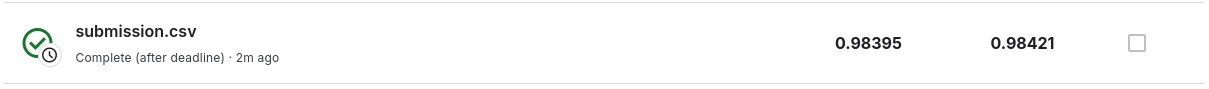

We consider this a great results when we take into account the fact that the best submission is only around 0.1-0.2% better

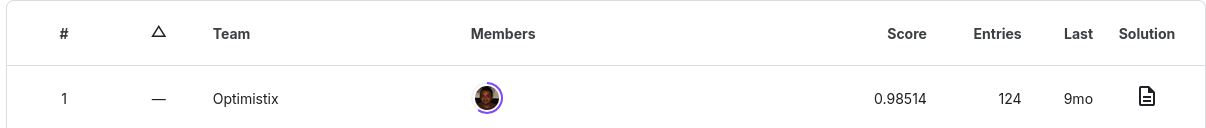

## 5. Future Work
This project demonstrates the feasibility of using supervised learning to classify mushrooms based on morphological and ecological features. However, several opportunities remain for further refinement and exploration:

- **Dimensionality reduction**: Future work could investigate more robust strategies for reducing feature space, including combining highly correlated variables, removing features with low mutual information, or experimenting with alternative dimensionality reduction techniques beyond those already applied.
- **More comprehensive model tuning**: While Optuna was effectively used to optimize the final model, it would have been ideal to apply this hyperparameter optimization framework to all evaluated models. Moreover, integrating model-specific tuning into feature selection and PCA, especially for distance-based models like KNN and SVM, could yield more tailored and performant solutions.
- **Exploring alternative models**: Given the large dataset size, future iterations of the project could experiment with deep learning approaches (e.g., MLPs) or compare performance across different boosting models (e.g., LightGBM, CatBoost).
- **More thorough data analysis**: Additional time could be invested in deeper exploratory data analysis to uncover latent structure, interactions between variables, and potential biases or artifacts in the dataset.
- **Advanced data preprocessing**: Alternative strategies for handling missing, infrequent, or outlier values could be explored, potentially through imputation, synthetic generation, or domain-specific grouping, to further enhance model robustness.
